In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

Instructions

Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

#### Read the data into a Pandas dataframe.

#### Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

#### Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

#### Create a logistic regression model to predict this variable from the cleaned data.

Evaluate the results.

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

#### Full queries on sql

Use sakila;


drop view if exists rented;


create view rented as


select i.film_id,if(max(r.rental_date)  like '%2006-02-14%','yes','no') as rented


from inventory as i


left join rental as r using (inventory_id) 


group by i.film_id


order by i.film_id;

###### second query


select f.film_id, f.rental_duration, f.rental_rate,f.rating,release_year,fc.category_id,


count(r.rental_ID) as times_rented, r2.rented


from film as f


join film_category as fc using(film_id)


join inventory as i using (film_id)


join rental as r using (inventory_id)


join rented as r2 using (film_id)


group by f.film_id


order by f.film_id;

In [7]:
query='''select f.film_id, f.rental_duration, f.rental_rate,f.rating,release_year,fc.category_id,
count(r.rental_ID) as times_rented, r2.rented
from film as f
join film_category as fc using(film_id)
join inventory as i using (film_id)
join rental as r using (inventory_id)
join rented as r2 using (film_id)
group by f.film_id
order by f.film_id;
'''

data = pd.read_sql_query(query, engine)
data.head()

,film_id,rental_duration,rental_rate,rating,release_year,category_id,times_rented,rented
0,1,6,0.99,PG,2006,6,24,no
1,2,3,4.99,G,2006,11,7,yes
2,3,7,2.99,NC-17,2006,6,12,no
3,4,5,2.99,G,2006,11,23,yes
4,5,6,2.99,G,2006,8,12,yes


In [8]:
data.isna().sum()

film_id            0
rental_duration    0
rental_rate        0
rating             0
release_year       0
category_id        0
times_rented       0
rented             0
dtype: int64

In [9]:
data = data.set_index("film_id")


In [10]:
data.head()

,rental_duration,rental_rate,rating,release_year,category_id,times_rented,rented
film_id,,,,,,,
1,6,0.99,PG,2006,6,24,no
2,3,4.99,G,2006,11,7,yes
3,7,2.99,NC-17,2006,6,12,no
4,5,2.99,G,2006,11,23,yes
5,6,2.99,G,2006,8,12,yes


In [11]:
rating_dict = {'G':1, 'PG':2, 'PG-13':3, 'R':4, 'NC-17':5}
data['rating'] = data['rating'].map(rating_dict)

In [12]:
data['rating'].head

<bound method NDFrame.head of film_id
1       2
2       1
3       5
4       1
5       1
       ..
996     1
997     5
998     5
999     4
1000    5
Name: rating, Length: 958, dtype: int64>

In [13]:
# Checking column release_year

data['release_year'].unique()

array([2006], dtype=int64)

In [14]:
# Taking out release year from data since only 2006

data = data.drop('release_year', axis=1)
data.head()

,rental_duration,rental_rate,rating,category_id,times_rented,rented
film_id,,,,,,
1,6,0.99,2,6,24,no
2,3,4.99,1,11,7,yes
3,7,2.99,5,6,12,no
4,5,2.99,1,11,23,yes
5,6,2.99,1,8,12,yes


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


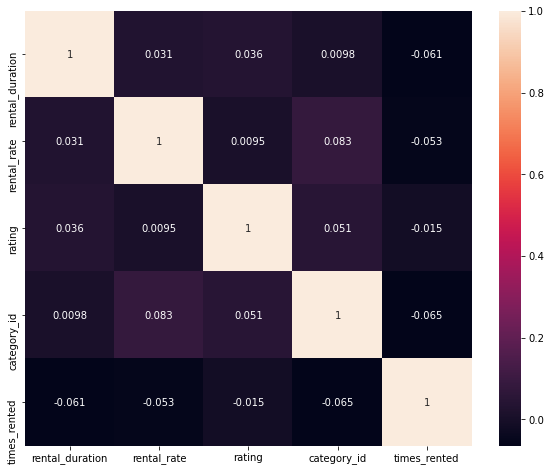

In [20]:
# Checking for cross-correlation of variables

corr_matrix = data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [21]:
data.head(20)

,rental_duration,rental_rate,rating,category_id,times_rented,rented
film_id,,,,,,
1,6,0.99,2,6,24,no
2,3,4.99,1,11,7,yes
3,7,2.99,5,6,12,no
4,5,2.99,1,11,23,yes
5,6,2.99,1,8,12,yes
6,3,2.99,2,9,21,no
7,6,4.99,3,5,15,no
8,6,4.99,4,11,18,no
9,3,2.99,3,11,12,no


In [22]:
y = data['rented']
x = data.drop(['rented'], axis = 1)

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=100)

In [24]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(x_train, y_train)

In [25]:
predictions = classification.predict(x_test)
classification.score(x_test, y_test)

0.8229166666666666

In [26]:
print("Accuracy of the model in TEST set is: ", round(classification.score(x_test, y_test),2))

Accuracy of the model in TEST set is:  0.82


In [27]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, predictions)

array([[316,   0],
       [ 68,   0]], dtype=int64)

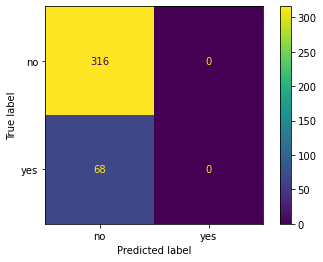

In [28]:
plot_confusion_matrix(classification, x_test, y_test)

## If the movie was rented last month how is it likely to be rented in the future?

### VERY UNLIKELY

The result produced by the confusion matrix is true negative:

The quadrants: 


False positive 0 = the staff think positively they will sell some title from the previous month is false, it does not happen


True positive 0= the staff think positively they will sell some title from the previous month and is true


False negative 68= the staff think they will sell nothing but instead they do sell some title from the previous month (it could happen)


True negative 316= the staff thinks the business is in bankrupt and they will sell nothing 
